# Immigration characteristics

In [1]:
import pandas as pd, numpy as np

! whoami
! date

zmbc
Mon Oct  3 16:21:19 PDT 2022


In [2]:
acs = pd.read_hdf('../data/acs_2020_5yr_person.hdf', key='acs')
acs_hh = pd.read_hdf('../data/acs_2020_5yr_household.hdf', key='acs')

In [3]:
len(acs)

15441673

In [4]:
len(acs_hh)

7426541

In [5]:
acs.PUMA.nunique()

982

In [6]:
acs['immigrant'] = (acs.MIG == 2).astype(int)
# For our purposes, GQ people (38, 39) are reference people for their "household" of 1
acs['immigrant_ref_person'] = ((acs.RELSHIPP.isin([20, 37, 38])) & (acs.immigrant == 1)).astype(int)

## Sample size considerations

How do we determine if these sample sizes are "big enough"?
Clearly, in the extreme case, some PUMAs will receive 0 immigration of a given type.
Or when there is only 1 ACS respondent to sample from, a PUMA will receive immigration only of exact clones.
But it is unclear whether this is actually a problem/whether it would be better to randomly assign PUMAs to immigrants,
given that immigration rates vary quite a bit by PUMA.

This could lead to some especially hard PRL, given that people who are similar (age will vary a bit, name/address will be independent) will
tend to accumulate, which seems like a significant downside of the nonparametric resampling approach.

In [7]:
def histogram(series, xlabel, ylabel, bins='max'):
    if bins == 'max':
        bins = series.max()
    a = series.hist(bins=bins)
    a.set_xlabel(xlabel)
    a.set_ylabel(ylabel)
    return a

<AxesSubplot:xlabel='Number of recent immigrants', ylabel='Count of PUMAs'>

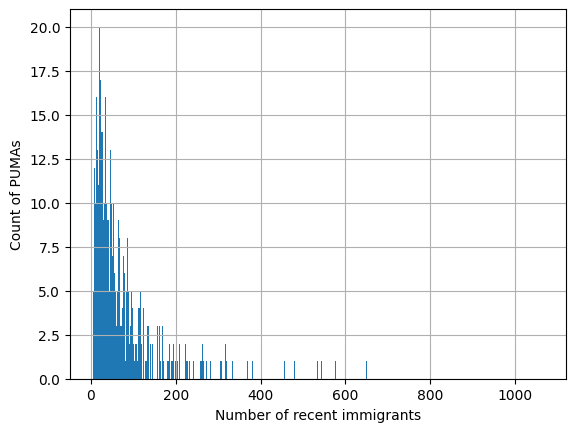

In [8]:
histogram(
    acs.groupby('PUMA').agg({'immigrant': 'sum', 'PWGTP': 'sum'}).immigrant,
    'Number of recent immigrants',
    'Count of PUMAs',
)

In [9]:
acs.groupby('PUMA').agg({'immigrant': 'sum', 'PWGTP': 'sum'}).immigrant.min()

4

<AxesSubplot:xlabel='Number of recent immigrant reference people', ylabel='Count of PUMAs'>

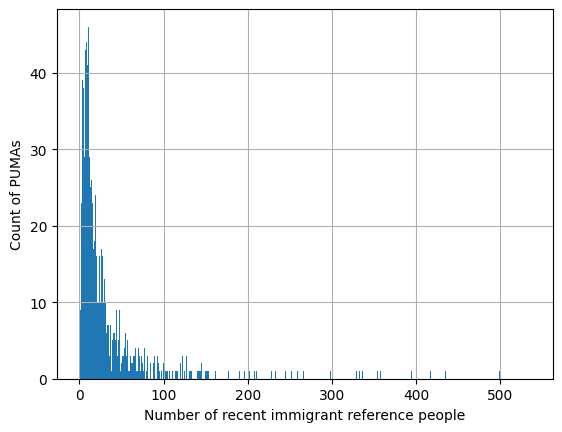

In [10]:
histogram(
    acs.groupby('PUMA').agg({'immigrant_ref_person': 'sum', 'PWGTP': 'sum'}).immigrant_ref_person,
    'Number of recent immigrant reference people',
    'Count of PUMAs',
)

In [11]:
acs.groupby('PUMA').agg({'immigrant_ref_person': 'sum', 'PWGTP': 'sum'}).immigrant_ref_person.min()

0

<AxesSubplot:xlabel='Rate of recent immigrants per 1,000 people', ylabel='Count of PUMAs'>

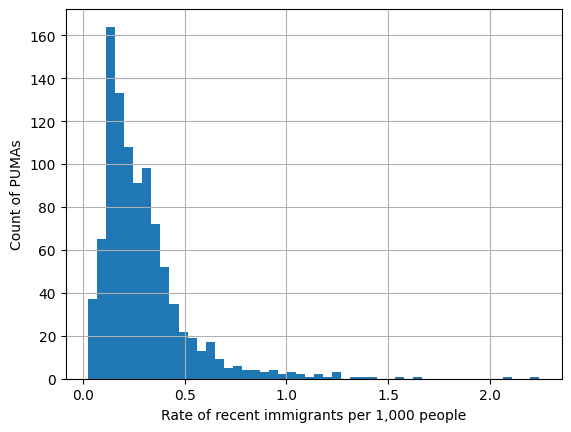

In [12]:
histogram(
    acs.groupby('PUMA').agg({'immigrant': 'sum', 'PWGTP': 'sum'}).assign(proportion=lambda x: x.immigrant / x.PWGTP * 1_000).proportion,
    'Rate of recent immigrants per 1,000 people',
    'Count of PUMAs',
    bins=50
)

In [13]:
acs.groupby('PUMA').agg({'immigrant': 'sum', 'PWGTP': 'sum'}).assign(proportion=lambda x: x.immigrant / x.PWGTP * 1_000).proportion.sort_values()

PUMA
5502     0.027083
3414     0.036300
55102    0.037093
3528     0.038849
3523     0.042063
           ...   
8604     1.428433
8501     1.551096
8612     1.651625
8608     2.065087
49003    2.240983
Name: proportion, Length: 982, dtype: float64

<AxesSubplot:xlabel='Rate of recent immigrant reference people per 1,000 people', ylabel='Count of PUMAs'>

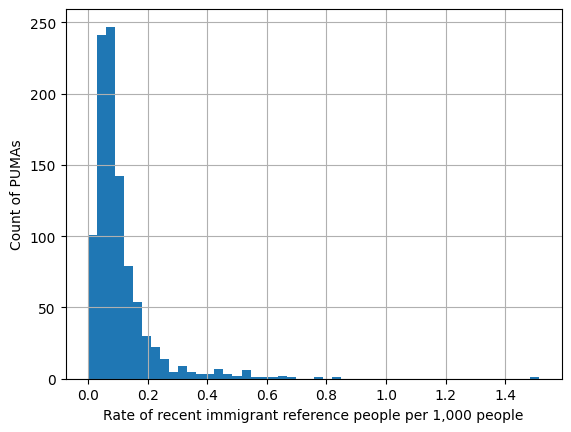

In [14]:
histogram(
    acs.groupby('PUMA').agg({'immigrant_ref_person': 'sum', 'PWGTP': 'sum'}).assign(proportion=lambda x: x.immigrant_ref_person / x.PWGTP * 1_000).proportion,
    'Rate of recent immigrant reference people per 1,000 people',
    'Count of PUMAs',
    bins=50
)

## PUMA distributions with no 0 values

In order to avoid some of the problems listed above (zero household immigration to some PUMAs,
similar people/households being sampled from the same ACS person), we will sometimes replace PUMA in the sampled person.
The replacement will come from the PUMA distribution among all moves of that type, but with a minimum value for each PUMA.

Because these distributions will be unconditional on age, sex, race, household structure, and other ACS columns, we
will lose some of the correlation these attributes have with PUMA for immigrants.
The amount of correlation lost is directly related to the probability with which we replace PUMA.

In [15]:
def normalize_probabilities(s):
    return s / s.sum()

### Household moves

In [16]:
household_moves = (acs.immigrant_ref_person == 1)

In [17]:
household_moves_with_weights = acs[household_moves].merge(acs_hh, on='SERIALNO', suffixes=('_p', '_hh')).assign(household_weight=lambda x: np.where(x.RELSHIPP == 20, x.WGTP, x.PWGTP))
assert np.all(household_moves_with_weights.household_weight > 0)
household_moves_with_weights

,RT_p,SERIALNO,DIVISION_p,SPORDER,PUMA_p,REGION_p,ST_p,ADJINC_p,PWGTP,AGEP,...,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80,household_weight
0,P,2016000004320,2,1,400,1,42,1086849,3,59,...,0,0,0,0,0,0,0,0,0,3
1,P,2016000004937,2,1,3002,1,42,1086849,18,73,...,33,5,19,20,19,5,18,17,31,17
2,P,2016000020598,2,1,3502,1,42,1086849,3,59,...,0,0,0,0,0,0,0,0,0,3
3,P,2016000020730,2,1,2600,1,42,1086849,1,55,...,0,0,0,0,0,0,0,0,0,1
4,P,2016000027882,2,1,1807,1,42,1086849,27,47,...,7,10,30,18,6,9,32,7,9,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31957,P,2020HU0986498,9,1,304,4,15,1006149,3,70,...,3,3,2,1,2,2,1,3,1,2
31958,P,2020HU1014043,9,1,306,4,15,1006149,5,48,...,3,1,5,7,2,6,4,4,5,5
31959,P,2020HU1048998,9,1,303,4,15,1006149,2,25,...,2,1,2,1,2,1,0,1,1,2
31960,P,2020HU1073512,9,1,307,4,15,1006149,10,70,...,11,11,3,16,10,9,17,9,17,10


In [18]:
household_moves_puma_distribution = normalize_probabilities(household_moves_with_weights.groupby('PUMA_hh').household_weight.sum()).reindex(acs.PUMA.unique(), fill_value=0)
household_moves_puma_distribution

PUMA_hh
4001     0.001564
1502     0.001149
2600     0.002962
1400     0.006633
2401     0.000539
           ...   
8606     0.000190
12704    0.000086
6002     0.000108
1008     0.000015
6001     0.000185
Name: household_weight, Length: 982, dtype: float64

In [19]:
min_value = np.percentile(household_moves_puma_distribution, 2.5)
min_value

4.3806221494365005e-05

In [20]:
household_moves_puma_distribution_filled = normalize_probabilities(household_moves_puma_distribution.mask(household_moves_puma_distribution < min_value, min_value))
household_moves_puma_distribution_filled

PUMA_hh
4001     0.001563
1502     0.001149
2600     0.002961
1400     0.006630
2401     0.000539
           ...   
8606     0.000190
12704    0.000086
6002     0.000108
1008     0.000044
6001     0.000185
Name: household_weight, Length: 982, dtype: float64

In [21]:
household_moves_puma_distribution_filled.reset_index().rename(columns={'PUMA_hh': 'PUMA', 'household_weight': 'probability'}).to_csv('household_moves_puma_distribution.csv', index=False)

In [22]:
assert household_moves_puma_distribution_filled.sum() == 1.0

### Non-reference-person moves

In [23]:
non_ref_person_moves = (acs.immigrant == 1) & (~acs.SERIALNO.isin(acs[household_moves].SERIALNO))

In [24]:
non_ref_person_moves_puma_distribution = normalize_probabilities(acs[non_ref_person_moves].groupby('PUMA').PWGTP.sum()).reindex(acs.PUMA.unique(), fill_value=0)
non_ref_person_moves_puma_distribution

PUMA
4001     0.002275
1502     0.001306
2600     0.002572
1400     0.004816
2401     0.001235
           ...   
8606     0.000696
12704    0.000141
6002     0.000043
1008     0.000333
6001     0.000187
Name: PWGTP, Length: 982, dtype: float64

In [25]:
min_value = np.percentile(non_ref_person_moves_puma_distribution, 2.5)
min_value

7.498279412670486e-05

In [26]:
non_ref_person_moves_puma_distribution_filled = normalize_probabilities(non_ref_person_moves_puma_distribution.mask(non_ref_person_moves_puma_distribution < min_value, min_value))
non_ref_person_moves_puma_distribution_filled

PUMA
4001     0.002273
1502     0.001305
2600     0.002571
1400     0.004813
2401     0.001234
           ...   
8606     0.000696
12704    0.000141
6002     0.000075
1008     0.000333
6001     0.000187
Name: PWGTP, Length: 982, dtype: float64

In [27]:
non_ref_person_moves_puma_distribution_filled.reset_index().rename(columns={'PWGTP': 'probability'}).to_csv('non_reference_person_moves_puma_distribution.csv', index=False)

In [28]:
assert non_ref_person_moves_puma_distribution_filled.sum() == 1.0